# Utilizing tf_geometric to build models

#### Issues encountered

-- A major issue with utilizing the tf_geomtric library is the lack of edge-attribute support. The information of a transaction can't be utilized in full to help predict if the node is malicious or not. 

-- Another issues with utilizing GCN is the massively imbalanced class distribution. 

### To-Do List --- August 1-3
- 1. _Add node features_
- 2. _Get the GCN to work with the new data_
- 3. Experiment with methods to compensate for unbalanced class distributtion
        - 1. Edit accuracy metric?
        - 2. Reweighting
            - Reweighting did not affect the training or predictions of the GCN. The GCN predicted all non-spam classes and would achieve a high accuracy as it is the majority class.
        - 3. Oversampling
            - Oversampling has definitely improved the training of the GCN. With oversampling, the GCN will predict both classes and achieves slightly better performance than random guessing would achieve.
        - 4. Penalized GCN?
            - Adding a penalty term to the dense layer seems to help the performance slightly, but still the performance is lackluster.
        - 5. Try anomaly detection?
- 4. _Experiment with parameter settings_


### To-Do List August 8-12

- 1. _Get Transfer Learning with the GCN model to work_
- 2. _Predict scam addresses on ERC1155 dataset_
- 3. _Research predicted addresses_
- 4. __Determine accuracy, f1 score, etc__


- 5. Use graph analysis to distinguish any potentially suspicious addresses

### Summary

##### Data
    Couldn't have lists within the dataframe so took the approach of utilizing min, max, median, mean statistics instead
    
##### Extremely Unbalanced Class Distribution
    There are a small number of addresses labeled as a 'scam' address, so initially, the GCN just predicts that every address is not a scam and achieves a very high accuracy and precision.
    
    To combat this issue, ...

In [322]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pyreadr
from sklearn.model_selection import train_test_split 
import networkx as nx
from ast import literal_eval
import graphviz
import pydot
import tf_geometric as tfg
from dfply import *
from sklearn.preprocessing import LabelEncoder
import math
from sklearn.metrics import DistanceMetric
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix
from tensorflow.keras import regularizers
import requests
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from urllib.request import Request, urlopen
import requests
from bs4 import BeautifulSoup


In [2]:
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [634]:
# Loading all ERC1155 data
#all_erc1155_data = pyreadr.read_r('data/ERC1155_data_07.rds') # also works for RData
#df_erc1155 = all_erc1155_data[None] # extract the pandas data frame 
all_erc1155_data = pyreadr.read_r('data/ERC1155_data_07_v2.rds') # also works for RData
df_erc1155 = all_erc1155_data[None] # extract the pandas data frame 



# Loading ERC20 data for train, validation sets
all_erc20_data = pd.read_csv('Dataset/Dataset.csv')



FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/Dataset.csv'

In [4]:
# Ensuring features are the same for both datasets
df_erc1155 = df_erc1155[['fromAddress', 'toAddress', 'data', 'blockNumber',
                        'transactionHash', 'transactionIndex', 'dateTime', 'priceETH',
                        'gasPrice', 'gasUsed']]

df_erc1155.columns = ['from_address', 'to_address', 'data', 'block_number',
                        'transaction_hash', 'transaction_index', 'timeStamp', 'priceETH',
                     'gas_price', 'receipt_gas_used']
df_erc1155['weight'] = df_erc1155['priceETH']


erc20_data_y = all_erc20_data[['from_scam', 'to_scam', 'from_category', 'to_category']]
erc20_data_y = pd.get_dummies(erc20_data_y, columns=['from_category', 'to_category'], prefix=["from_scam", "to_scam"])


erc20_data_X = all_erc20_data[['hash', 'transaction_index', 'from_address', 'to_address', 
                          'value', 'input', 'block_timestamp', 'block_number', 
                               'gas_price', 'receipt_gas_used', 'from_scam', 'to_scam']]
erc20_data_X.columns = ['transaction_hash', 'transaction_index', 'from_address', 'to_address', 
                          'priceWei', 'data', 'timeStamp', 'block_number', 'gas_price', 
                        'receipt_gas_used', 'from_scam', 'to_scam']

erc20_data_X['priceETH'] = erc20_data_X['priceWei']/1000000000000000000.00
erc20_data_X.drop(columns=['priceWei'])
#erc20_data_X['weight'] = erc20_data_X['priceETH']




,transaction_hash,transaction_index,from_address,to_address,data,timeStamp,block_number,gas_price,receipt_gas_used,from_scam,to_scam,priceETH
0,0x253ec84729f5c11437f5346830e6bdc9857171b16097...,4,0x267be1c1d684f78cb4f6a176c4911b741e4ffdc0,0xd707ac0098599006f0857e8da4c950795645ba01,0x,2017-10-16 05:26:53 UTC,4370008,2.205000e+10,21000,0,0,1.8000
1,0xfa5f1d7715562adb1e408fdbbbbfc033ae4fadca1e07...,85,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xb8f6e76d34d4877732dfefa6b6a4e2a834a9092b,0x,2017-10-16 05:28:49 UTC,4370014,2.060947e+10,21000,0,0,0.0075
2,0x37928f1d12ee769d0876695aaa815c13d705f8b1e376...,31,0x304cc179719bc5b05418d6f7f6783abe45d83090,0x5ec492652d7b92421680f21169ff6a8dbbc622ab,0x,2017-10-16 05:29:19 UTC,4370015,2.060947e+10,21000,0,0,0.0075
3,0xaad886f331a2fb40495cdf5faa10882852fcd324f064...,78,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xdf01b231b53d8b4cbb1b092a8dc86730cebf4aa9,0x,2017-10-16 05:29:43 UTC,4370016,2.060947e+10,21000,0,0,0.0075
4,0x3dbe36fd1a1b01b5e1b343ff78ec1ec189feee5acf46...,83,0x304cc179719bc5b05418d6f7f6783abe45d83090,0xaa4b9693c54029d180134161cc99e98b76cea249,0x,2017-10-16 05:29:43 UTC,4370016,2.060947e+10,21000,0,0,0.0075
...,...,...,...,...,...,...,...,...,...,...,...,...
71245,0x3ea1ea78fe7107fa15f667266c66dc63786b6470dbd1...,204,0x7c9001c50ea57c1b2ec1e3e63cf04c297534bfc1,0x4fed1fc4144c223ae3c1553be203cdfcbd38c581,0x,2019-12-26 10:28:03+00:00,9165303,3.000000e+09,21000,1,0,0.6530
71246,0x29931318eac76fb7ec086cbfaee3d95994c554a466f4...,101,0xf49874712828e3d73a12c15f9f77c5529eb0632f,0x7c9001c50ea57c1b2ec1e3e63cf04c297534bfc1,0x,2019-12-30 05:40:39+00:00,9184428,5.000000e+09,21000,0,1,1.0900
71247,0x71741c64fff59755c32e14e0fa53bc4a4ad51ff3545a...,201,0x7c9001c50ea57c1b2ec1e3e63cf04c297534bfc1,0x4fed1fc4144c223ae3c1553be203cdfcbd38c581,0x,2019-12-30 05:46:10+00:00,9184447,1.500000e+09,21000,1,0,1.0900
71248,0x28fb91f62b1948d044db2db46411ea0042473d158353...,36,0xf49874712828e3d73a12c15f9f77c5529eb0632f,0x7c9001c50ea57c1b2ec1e3e63cf04c297534bfc1,0x,2019-12-30 12:58:56+00:00,9185936,6.000000e+09,21000,0,1,0.0480


In [5]:
# Convert hexadecimal to decimal
df_erc1155['gas'] = [literal_eval(y) if y != '0x' and type(y) != int else y for y in df_erc1155['receipt_gas_used']]



###### ERC20 Dataset

In [6]:
# Creating scam/not-scam labelled addresses for ERC20 dataset

from_addresses = all_erc20_data >> select(X.from_address, X.from_scam)
to_addresses = all_erc20_data >> select(X.to_address, X.to_scam)

labelled_addresses = pd.merge(from_addresses, to_addresses, how = 'outer',
                             left_on = 'from_address', right_on = 'to_address')


labelled_addresses['address'] = labelled_addresses['from_address'].fillna(labelled_addresses['to_address'])
labelled_addresses['label'] = labelled_addresses['from_scam'].fillna(labelled_addresses['to_scam']).astype('int32')

labelled_addresses = labelled_addresses.drop_duplicates()
labelled_addresses = (labelled_addresses >> select(X.address, X.label)).reset_index(drop = True)

labelled_addresses.shape


(73034, 2)

In [7]:
# This block of code is unused as there are more issues when trying deal with 
# multiple categories with very few instances

# Creating specific kind of scam labelled addresses for ERC20 dataset
#le = LabelEncoder()

#from_addresses = all_erc20_data >> select(X.from_address, X.from_category)
#to_addresses = all_erc20_data >> select(X.to_address, X.to_category)

#from_addresses['from_category'] = (le.fit_transform(from_addresses['from_category']))
#from_addresses['from_category'] = from_addresses['from_category'].astype('category')


#mapping_dict = dict(zip(le.classes_, le.transform(le.classes_)))
#to_addresses['to_category'] = to_addresses['to_category'].map(mapping_dict)

#labelled_addresses_cats = pd.merge(from_addresses, to_addresses, how = 'outer',
#                             left_on = 'from_address', right_on = 'to_address')

#labelled_addresses_cats['address'] = labelled_addresses_cats['from_address'].fillna(labelled_addresses_cats['to_address'])
#labelled_addresses_cats['label'] = labelled_addresses_cats['from_category'].fillna(labelled_addresses_cats['to_category']).astype('int32')

#labelled_addresses_cats = labelled_addresses_cats.drop_duplicates()
#labelled_addresses_cats = (labelled_addresses_cats >> select(X.address, X.label)).reset_index(drop = True)


#labelled_addresses_cats.shape

In [161]:
G =  nx.from_pandas_edgelist(df = erc20_data_X, source='from_address', 
                                        target='to_address',
                                        edge_attr = ['transaction_hash', 'transaction_index', 
                                         'priceETH', 'timeStamp', 'block_number', 'gas_price',
                                         'receipt_gas_used'],
                                       create_using = nx.DiGraph())
df_nodes = pd.DataFrame({'node_id': G.nodes})

df_eig_centrality = pd.DataFrame.from_dict(nx.eigenvector_centrality_numpy(G), orient='index').reset_index()
df_eig_centrality.rename(columns={'index':'node_id', 0:'eigenvector_centrality'}, inplace=True)

df_pangerank = pd.DataFrame.from_dict(nx.pagerank(G), orient='index').reset_index()
df_pangerank.rename(columns={'index':'node_id', 0:'pagerank'}, inplace=True)

df_in_degree = pd.DataFrame.from_dict(dict(G.in_degree(G.nodes)), orient='index').reset_index()
df_in_degree.rename(columns={'index':'node_id', 0:'in_degree'}, inplace=True)

df_out_degree = pd.DataFrame.from_dict(dict(G.out_degree(G.nodes)), orient='index').reset_index()
df_out_degree.rename(columns={'index':'node_id', 0:'out_degree'}, inplace=True)

df_nodes = df_nodes.merge(df_eig_centrality, on='node_id')
df_nodes = df_nodes.merge(df_pangerank, on='node_id')
df_nodes = df_nodes.merge(df_in_degree, on='node_id')
df_nodes = df_nodes.merge(df_out_degree, on='node_id')


In [9]:
#df_nodes

In [10]:

#Convert block_timestamp to timestamps
all_erc20_data['block_timestamp'] = pd.to_datetime(all_erc20_data['block_timestamp']).astype(int)

# For every from_address, collect the timestamps
adr_timestamp = (all_erc20_data >> select(X.from_address, X.block_timestamp) >>
mutate(timestamps = X.block_timestamp) >> #(X.block_timestamp).to_numpy(dtype = np.float32)) >>
select(~X.block_timestamp))

adr_timestamp = (adr_timestamp >> group_by(X.from_address) >>
summarize(min_timestamp = X.timestamps.min(),
      max_timestamp = (X.timestamps).max(),
      med_timestamp = (X.timestamps).median(),
      mean_timestamp = (X.timestamps).mean()))


# For every from_address, collect the reciept_gas/gas_used
adr_gas = (all_erc20_data >> select(X.from_address, X.receipt_gas_used) >>
mutate(gas = (X.receipt_gas_used).to_numpy(dtype = np.float32)) >>
select(~X.receipt_gas_used))
                
adr_gas = (adr_gas >> group_by(X.from_address) >>
summarize(min_gas = X.gas.min(),
      max_gas = (X.gas).max(),
      med_gas = (X.gas).median(),
      mean_gas = (X.gas).mean()))


# For every from_address, count the number of transactions made
outgoing_count = (all_erc20_data >> select(X.from_address) >> 
group_by(X.from_address) >> summarize(out_count = (X.from_address).count()))


# For every from_address, count the number of incoming transactions
incoming_count = (all_erc20_data >> select(X.to_address) >> 
group_by(X.to_address) >> summarize(in_count = (X.to_address).count()))

# For every from_address, calculate the value of outgoing transactions
outgoing_val = (erc20_data_X >> select(X.from_address, X.priceETH) >>
#group_by(X.from_address) >> summarize(outgoing_priceETH = (X.priceETH).to_numpy(dtype = np.float32)) >>
#ungroup()) #>> select(~X.outgoing_priceETH))
mutate(outgoing_priceETH = (X.priceETH).to_numpy(dtype = np.float32)) >>
select(~X.priceETH))
                
outgoing_val = (outgoing_val >> group_by(X.from_address) >>
summarize(min_outgoing_priceETH = X.outgoing_priceETH.min(), #>>
      max_outgoing_priceETH = (X.outgoing_priceETH).max(),
      med_outgoing_priceETH = (X.outgoing_priceETH).median(),
      mean_outgoing_priceETH = (X.outgoing_priceETH).mean()))# >>

# For every to_address, calculate the value of incoming transactions
incoming_val = (erc20_data_X >> select(X.to_address, X.priceETH) >>
mutate(incoming_priceETH = (X.priceETH).to_numpy(dtype = np.float32)) >>
select(~X.priceETH))
                
incoming_val = (incoming_val >> group_by(X.to_address) >>
summarize(min_incoming_priceETH = X.incoming_priceETH.min(), #>>
      max_incoming_priceETH = (X.incoming_priceETH).max(),
      med_incoming_priceETH = (X.incoming_priceETH).median(),
      mean_incoming_priceETH = (X.incoming_priceETH).mean())) #>>



In [162]:
######## Creating Node Feature Matrix X ########

feature_matrix_1 = pd.merge(adr_timestamp, adr_gas, how = 'outer', on = 'from_address')
feature_matrix_2 = pd.merge(outgoing_count, outgoing_val, how = 'outer', on = 'from_address')
feature_matrix_3 = pd.merge(feature_matrix_1, feature_matrix_2, how = 'outer', on = 'from_address')

feature_matrix_4 = pd.merge(incoming_count, incoming_val, how = 'outer', on = 'to_address')

feature_matrix = pd.merge(feature_matrix_3, feature_matrix_4, how = 'outer', 
                          left_on = 'from_address', right_on = 'to_address')

feature_matrix['address'] = feature_matrix['from_address'].fillna(feature_matrix['to_address'])
feature_matrix = (feature_matrix >> select(~X.to_address, ~X.from_address))

feature_matrix = feature_matrix.drop_duplicates(subset = 'address')

feature_matrix = pd.merge(feature_matrix, df_nodes, how = 'outer', 
                          left_on = 'address', right_on = 'node_id')
feature_matrix = feature_matrix >> select(~X.node_id)


In [163]:
feature_matrix.head()

,min_timestamp,max_timestamp,med_timestamp,mean_timestamp,min_gas,max_gas,med_gas,mean_gas,out_count,min_outgoing_priceETH,...,in_count,min_incoming_priceETH,max_incoming_priceETH,med_incoming_priceETH,mean_incoming_priceETH,address,eigenvector_centrality,pagerank,in_degree,out_degree
0,1.518234e+18,1.518234e+18,1.518234e+18,1.518234e+18,21000.0,21000.0,21000.0,21000.0,1.0,0.10000,...,NaN,NaN,NaN,NaN,NaN,0x00005b859f8fac331d73c5c70f74238876727498,-6.081439e-21,0.000009,0,1
1,1.513671e+18,1.513671e+18,1.513671e+18,1.513671e+18,21000.0,21000.0,21000.0,21000.0,1.0,0.00827,...,NaN,NaN,NaN,NaN,NaN,0x00019beb6f68d1268288b6a458a8fd90dd266455,1.341254e-20,0.000009,0,1
2,1.519282e+18,1.519282e+18,1.519282e+18,1.519282e+18,21000.0,21000.0,21000.0,21000.0,1.0,2.99000,...,NaN,NaN,NaN,NaN,NaN,0x000352b4652dc4000c3e25f4ebc159a69f471531,1.413387e-20,0.000009,0,1
3,1.508164e+18,1.508164e+18,1.508164e+18,1.508164e+18,21000.0,21000.0,21000.0,21000.0,1.0,0.10000,...,NaN,NaN,NaN,NaN,NaN,0x00038c2a3748fec0d18a3119d74577e450f6acbb,9.739600e-21,0.000009,0,1
4,1.518340e+18,1.518340e+18,1.518340e+18,1.518340e+18,21000.0,21000.0,21000.0,21000.0,1.0,0.91200,...,NaN,NaN,NaN,NaN,NaN,0x000398c693a4c60109d003f92c512c2510f71608,1.907576e-20,0.000009,0,1


In [621]:
######## Creating Adjacency Matrix A (edge_index, edge_weight) ########

# Add labels to feature matrix to ensure order of labels and addresses

feature_matrix_lbls = pd.merge(feature_matrix, labelled_addresses, how = 'left',
                              on = 'address')


#############################

adr_ind_dict = dict(zip(feature_matrix['address'], np.arange(len(feature_matrix['address']))))

edge_Index_1 = [adr_ind_dict[adr] for adr in erc20_data_X['from_address']]
edge_Index_2 = [adr_ind_dict[adr] for adr in erc20_data_X['to_address']]

#############################

edge_Index = np.array([edge_Index_1, edge_Index_2])


edge_Weight = np.array(erc20_data_X['priceETH'], dtype=np.float32)

#A = (edge_Index, edge_Weight)

edge_Index.shape, edge_Weight.shape

#edge_index_dict = dict(zip(edge_Index_1, edge_Index_2))
#index_weight_dict = dict(zip(zip(edge_Index_1, edge_Index_2), edge_Weight))



((2, 71250), (71250,))

# Building Graphs

In [622]:
# Creating the Y list (of labels)
y = feature_matrix_lbls >> select(X.label)
y = np.array(y).astype(np.int32)
y = np.reshape(y, (-1))

X_feats = feature_matrix_lbls >> select(~X.label)

# Drop the address column from X
X_feats = X_feats >> select(~X.address)


In [623]:
# Converting feature matrix to useable form for graph
X_feats.fillna(-1, inplace=True)

#X_feats = np.asarray(X_feats)#.astype(np.float32)
#X_feats = np.reshape(X_feats, (73034,18))


In [624]:

X_feats_new = np.asarray(X_feats)#.astype(np.float32)
X_feats_new = np.reshape(X_feats_new, (73034,-1))

y_new = y

# GCN Utilizing tf_geometric

In [14]:
## Soruce: https://tf-geometric.readthedocs.io/en/latest/modules/root.html#graph-data-structure-for-a-single-graph


In [625]:

X_feats_new = feature_matrix_lbls >> select(~X.label)
X_feats_new.fillna(-1, inplace=True)


In [626]:
indices = np.arange(len(X_feats_new))
(_, _, _, _, train_index, test_index) = train_test_split(X_feats_new,
                                                         y_new,
                                                         indices, test_size = 0.4,
                                                         stratify = y_new,
                                                        random_state = 0)
valid_index = test_index[0:int(len(test_index) * .625)]
test_index = test_index[int(len(test_index) * .375):len(test_index)]

X_feats = X_feats_new >> select(~X.address)

X_feats = np.asarray(X_feats)
X_feats = np.reshape(X_feats, (73034,-1))

# Normalize according to training data
# Z-Normalization
#mean = np.mean(X_feats[train_index], axis=0)
#std = np.std(X_feats[train_index], axis=0)
#X_feats[train_index] -= mean
#X_feats[valid_index] -= mean
#X_feats[test_index] -= mean
#X_feats[train_index] /= std
#X_feats[valid_index] /= std
#X_feats[test_index] /= std

#Min/Max Normalization
X_min = np.min(X_feats[train_index], axis=0)
X_max = np.max(X_feats[train_index], axis=0)
X_feats[train_index] -= X_min
X_feats[valid_index] -= X_min
X_feats[test_index] -= X_min
X_feats[train_index] /= (X_max - X_min)
X_feats[valid_index] /= (X_max - X_min)
X_feats[test_index] /= (X_max - X_min)

######### Oversampling ######### 
from imblearn.over_sampling import RandomOverSampler

#over = RandomOverSampler(sampling_strategy = 0.10) #10
#XX, yy = over.fit_resample(X_feats_new.iloc[train_index], y_new[train_index])
#train_index = train_index[over.sample_indices_]

over2 = RandomOverSampler(sampling_strategy = 0.05) # 0.05
XX2, yy2 = over2.fit_resample(X_feats_new.iloc[valid_index], y_new[valid_index])
valid_index = valid_index[over2.sample_indices_]



In [627]:
sorted(Counter(np.array(y_new[train_index])).items()), 


([(0, 43719), (1, 101)],)

In [629]:
from tf_geometric.utils import tf_utils

graph = ERC20_Graph

# @tf_utils.function can speed up functions for TensorFlow 2.x
@tf_utils.function
def forward(graph, training=False):
    return model([graph.x, graph.edge_index, graph.edge_weight], 
                 training=training, cache=graph.cache)


@tf_utils.function
def compute_loss(logits, mask_index, vars):
    masked_logits = tf.gather(logits, mask_index)
    masked_labels = tf.gather(graph.y, mask_index)
    losses = tf.nn.softmax_cross_entropy_with_logits(
        logits = masked_logits,
        labels = tf.one_hot(masked_labels, depth=num_classes),)

    kernel_vals = [var for var in vars if "kernel" in var.name]
    l2_losses = [tf.nn.l2_loss(kernel_var) for kernel_var in kernel_vals]
    cls_loss = tf.reduce_mean(losses)
    l2_loss = tf.add_n(l2_losses)
    return cls_loss + l2_loss * l2_coef, cls_loss, l2_loss


@tf_utils.function
def evaluate(current_test_index):
    with tf.GradientTape() as tape:
        logits = forward(graph)
        loss = compute_loss(logits, current_test_index, tape.watched_variables())
    masked_logits = tf.gather(logits, current_test_index)
    masked_labels = tf.gather(graph.y, current_test_index)
    y_pred = tf.argmax(masked_logits, axis=-1, output_type=tf.int32)
    
    corrects = tf.equal(y_pred, masked_labels)
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

    return accuracy, loss


@tf_utils.function
def evaluate_test():
    return evaluate(test_index)


@tf_utils.function
def evaluate_val():
    return evaluate(valid_index)

@tf_utils.function
def train_step():

    over = RandomOverSampler(sampling_strategy = 0.1)
    XX, yy = over.fit_resample(graph.x[train_index], graph.y[train_index])
    train_index2 = train_index[over.sample_indices_]

    with tf.GradientTape() as tape:
        logits = forward(graph, training=True)
        loss, _, _ = compute_loss(logits, train_index2, tape.watched_variables())
    vars = tape.watched_variables()
    grads = tape.gradient(loss, vars)
    optimizer.apply_gradients(zip(grads, vars))
    
    ###
    masked_logits = tf.gather(logits, train_index2)
    masked_labels = tf.gather(graph.y, train_index2)
    y_pred = tf.argmax(masked_logits, axis=-1, output_type=tf.int32)

    corrects = tf.equal(y_pred, masked_labels)    
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))
    ###
    return accuracy, loss

@tf_utils.function
def predict(test_index):
    logits = forward(graph)
    masked_logits = tf.gather(logits, test_index)
    y_pred = tf.argmax(masked_logits, axis=-1, output_type=tf.int32)

    return y_pred

In [630]:
ERC20_Graph = tfg.Graph(x = X_feats,
                        y = y_new,
                        edge_index = edge_Index,
                        edge_weight = edge_Weight).to_directed()



In [631]:
### GCN ###
# Source: https://github.com/CrawlScript/tf_geometric/blob/master/benchmarks/node_classification/bench_node_cls_early_stop_gcn.py

#tf.config.run_functions_eagerly(True)

patience = 4

num_classes = ERC20_Graph.y.max() + 1
drop_rate = 0.25 #0.25
l2_coef = 5e-3

# Multi-layer GCN Model
class GCNModel(keras.Model):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gcn0 = tfg.layers.GCN(12, activation=tf.nn.relu, improved = True,
                                    edge_drop_rate = drop_rate,
                                  renorm = True)
                
        self.gcn4 = tfg.layers.GCN(8, activation = tf.nn.relu, improved = True,
                                  edge_drop_rate = drop_rate)

        self.dense = tf.keras.layers.Dense(2,)

        
    def call(self, inputs, training=None, mask=None, cache=None):
        x, edge_index, edge_weight = inputs
        h = self.gcn0([x, edge_index, edge_weight], training = training, cache=cache)
        h = self.gcn4([h, edge_index, edge_weight], training = training, cache=cache)
        h = self.dense(h, training = training)
        return h


ETH_model = GCNModel()
model = ETH_model
model.gcn0.build_cache_for_graph(ERC20_Graph)

TC =  tf.keras.callbacks.TensorBoard(log_dir='./logs', 
                                     write_graph = True, write_images = True)
TC.set_model(model)

optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.006,)#0.0075 )

model.compile(optimizer = optimizer,)


In [297]:

val_accuracy_list = []
loss_list = []

best_val_accuracy = 0
min_val_loss = 1000

final_step = None

patience_counter = 0

num_steps = 5121

for step in range(1, num_steps):

    #loss = train_step()
    accuracy, loss = train_step()

    if step % 28 == 0: #28
        val_accuracy, (_, val_loss, _) = evaluate_val()
        val_accuracy = val_accuracy#.numpy()
        val_loss = val_loss.numpy()
        
        # then after each epoch
        logs = {'acc': accuracy, 'loss': loss, 
                'val_loss': val_loss, 'val_acc': val_accuracy}
        TC.on_epoch_end(int(step), logs)

        if val_accuracy > best_val_accuracy or val_loss < min_val_loss:
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                break

        if val_accuracy > best_val_accuracy and val_loss < min_val_loss:
            final_step = step

            best_val_accuracy = val_accuracy
            min_val_loss = val_loss

        val_accuracy_list.append(val_accuracy)
        loss_list.append(val_loss)

        print("step = {}\taccuracy = {:.4f}\tloss = {:.4f}\tval_accuracy = {:.4f}\tval_loss = {:.4f}\tfinal_step = {}"
            .format(step, accuracy, loss, val_accuracy, val_loss, final_step))       
        print("patience_counter = {}".format(patience_counter))

TC.on_train_end('_')


#model.summary()

step = 28	accuracy = 0.9091	loss = 0.5013	val_accuracy = 0.9524	val_loss = 0.3891	final_step = 28
patience_counter = 0
step = 56	accuracy = 0.9091	loss = 0.3813	val_accuracy = 0.9524	val_loss = 0.2826	final_step = 28
patience_counter = 0
step = 84	accuracy = 0.9091	loss = 0.3276	val_accuracy = 0.9524	val_loss = 0.2261	final_step = 28
patience_counter = 0
step = 112	accuracy = 0.9091	loss = 0.3097	val_accuracy = 0.9524	val_loss = 0.2037	final_step = 28
patience_counter = 0
step = 140	accuracy = 0.9091	loss = 0.3030	val_accuracy = 0.9524	val_loss = 0.1938	final_step = 28
patience_counter = 0
step = 168	accuracy = 0.9099	loss = 0.2932	val_accuracy = 0.9524	val_loss = 0.1859	final_step = 28
patience_counter = 0
step = 196	accuracy = 0.9113	loss = 0.2867	val_accuracy = 0.9536	val_loss = 0.1798	final_step = 196
patience_counter = 0
step = 224	accuracy = 0.9127	loss = 0.2836	val_accuracy = 0.9575	val_loss = 0.1733	final_step = 224
patience_counter = 0
step = 252	accuracy = 0.9155	loss = 0.282

In [376]:
!tensorboard --logdir logs


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [298]:
preds = predict(test_index)
print('F1 Score: ', f1_score(graph.y[test_index], preds),
      '\n Accuracy Score: ', accuracy_score(graph.y[test_index], preds),
     '\n Predictions were: ', sorted(Counter(np.array(preds)).items()),
     '\n Actual Results: ', sorted(Counter(np.array(graph.y[test_index])).items()))

F1 Score:  0.3953488372093023 
 Accuracy Score:  0.9971520893805794 
 Predictions were:  [(0, 18219), (1, 40)] 
 Actual Results:  [(0, 18213), (1, 46)]


In [299]:
# Finding number of false positives
false_scam = len(preds[(preds != graph.y[test_index]) & (preds == 1)])

print((false_scam / len(preds[(preds == 1)]))*100, '% of scam predictions were incorrect.')

57.49999999999999 % of scam predictions were incorrect.


In [632]:

transform = TSNE

node_reps = model.gcn4([model.gcn0([graph.x, edge_Index, edge_Weight]), edge_Index, edge_Weight])
X_reps = tf.keras.backend.get_value(node_reps)
trans = transform(n_components = 2, perplexity=50)
X_reps = trans.fit_transform(X_reps)

X_reps.shape

(73034, 2)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


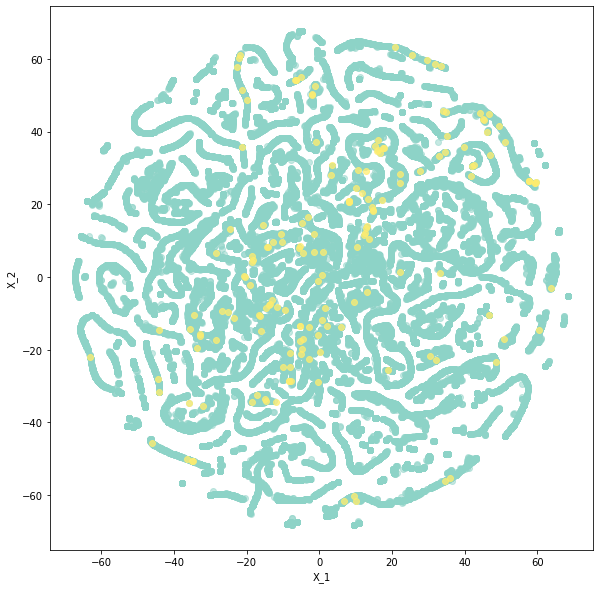

In [633]:
X_pd = pd.DataFrame({'X_0':X_reps[:,0],
                     'X_1':X_reps[:,1],
                    'y':y_new})

X_non = X_pd[X_pd['y']==0]

X_scam = X_pd[X_pd['y']==1]

fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(X_non['X_0'],
           X_non['X_1'],
          c=plt.cm.Set3(0),
          alpha=0.5)
ax.scatter(X_scam['X_0'],
           X_scam['X_1'],
          c=plt.cm.Set3(plt.cm.Set3.N),
          alpha=0.75)

ax.set(aspect='equal',
      xlabel='X_1',
      ylabel='X_2',)

plt.savefig('TSNE_ETH.jpeg')

# GCN ERC-1155

#### ERC1155 Dataset

In [252]:
# Removing all transactions with the null_address 0x0000000000000000000000000000000000000000

df_erc1155 = (df_erc1155 >> mask(X.from_address != '0x0000000000000000000000000000000000000000', 
                              X.to_address != '0x0000000000000000000000000000000000000000'))



In [253]:

#Convert block_timestamp to timestamps
df_erc1155['timeStamp'] = pd.to_datetime(df_erc1155['timeStamp']).astype(int)

# For every from_address, collect the timestamps
adr_timestamp_1155 = (df_erc1155 >> select(X.from_address, X.timeStamp) >>
mutate(timestamps = X.timeStamp) >> #(X.block_timestamp).to_numpy(dtype = np.float32)) >>
select(~X.timeStamp))

adr_timestamp_1155 = (adr_timestamp_1155 >> group_by(X.from_address) >>
summarize(min_timestamp = X.timestamps.min(),
      max_timestamp = (X.timestamps).max(),
      med_timestamp = (X.timestamps).median(),
      mean_timestamp = (X.timestamps).mean()))


# For every from_address, collect the reciept_gas/gas_used
adr_gas_1155 = (df_erc1155 >> select(X.from_address, X.gas) >>
mutate(gas_used = (X.gas).to_numpy(dtype = np.float32)) >>
select(~X.gas))
                
adr_gas_1155 = (adr_gas_1155 >> group_by(X.from_address) >>
summarize(min_gas = X.gas_used.min(),
      max_gas = (X.gas_used).max(),
      med_gas = (X.gas_used).median(),
      mean_gas = (X.gas_used).mean()))


# For every from_address, count the number of transactions made
outgoing_count_1155 = (df_erc1155 >> select(X.from_address) >> 
group_by(X.from_address) >> summarize(out_count = (X.from_address).count()))


# For every from_address, count the number of incoming transactions
incoming_count_1155 = (df_erc1155 >> select(X.to_address) >> 
group_by(X.to_address) >> summarize(in_count = (X.to_address).count()))

# For every from_address, calculate the value of outgoing transactions
outgoing_val_1155 = (df_erc1155 >> select(X.from_address, X.priceETH) >>
mutate(outgoing_priceETH = (X.priceETH).to_numpy(dtype = np.float32)) >>
select(~X.priceETH))
                
outgoing_val_1155 = (outgoing_val_1155 >> group_by(X.from_address) >>
summarize(min_outgoing_priceETH = X.outgoing_priceETH.min(), #>>
      max_outgoing_priceETH = (X.outgoing_priceETH).max(),
      med_outgoing_priceETH = (X.outgoing_priceETH).median(),
      mean_outgoing_priceETH = (X.outgoing_priceETH).mean()))# >>

# For every to_address, calculate the value of incoming transactions
incoming_val_1155 = (df_erc1155 >> select(X.to_address, X.priceETH) >>
mutate(incoming_priceETH = (X.priceETH).to_numpy(dtype = np.float32)) >>
select(~X.priceETH))
                
incoming_val_1155 = (incoming_val_1155 >> group_by(X.to_address) >>
summarize(min_incoming_priceETH = X.incoming_priceETH.min(), #>>
      max_incoming_priceETH = (X.incoming_priceETH).max(),
      med_incoming_priceETH = (X.incoming_priceETH).median(),
      mean_incoming_priceETH = (X.incoming_priceETH).mean())) #>>


In [254]:
G_1155 =  nx.from_pandas_edgelist(df = df_erc1155, source='from_address', 
                                        target='to_address',
                                        edge_attr = ['transaction_hash', 'transaction_index', 
                                         'priceETH', 'timeStamp', 'block_number', 'gas_price',
                                         'receipt_gas_used'],
                                       create_using = nx.DiGraph())
df_nodes_1155 = pd.DataFrame({'node_id': G_1155.nodes})

df_eig_centrality_1155 = pd.DataFrame.from_dict(nx.eigenvector_centrality_numpy(G_1155), orient='index').reset_index()
df_eig_centrality_1155.rename(columns={'index':'node_id', 0:'eigenvector_centrality'}, inplace=True)

df_pangerank_1155 = pd.DataFrame.from_dict(nx.pagerank(G_1155), orient='index').reset_index()
df_pangerank_1155.rename(columns={'index':'node_id', 0:'pagerank'}, inplace=True)

df_in_degree_1155 = pd.DataFrame.from_dict(dict(G.in_degree(G_1155.nodes)), orient='index').reset_index()
df_in_degree_1155.rename(columns={'index':'node_id', 0:'in_degree'}, inplace=True)

df_out_degree_1155 = pd.DataFrame.from_dict(dict(G.out_degree(G_1155.nodes)), orient='index').reset_index()
df_out_degree_1155.rename(columns={'index':'node_id', 0:'out_degree'}, inplace=True)

df_nodes_1155 = df_nodes.merge(df_eig_centrality_1155, on='node_id')
df_nodes_1155 = df_nodes.merge(df_pangerank_1155, on='node_id')
df_nodes_1155 = df_nodes.merge(df_in_degree_1155, on='node_id')
df_nodes_1155 = df_nodes.merge(df_out_degree_1155, on='node_id')



In [302]:
######## Creating Node Feature Matrix X ########

feature_matrix_1 = pd.merge(adr_timestamp_1155, adr_gas_1155, how = 'outer', on = 'from_address')
feature_matrix_2 = pd.merge(outgoing_count_1155, outgoing_val_1155, how = 'outer', on = 'from_address')
feature_matrix_3 = pd.merge(feature_matrix_1, feature_matrix_2, how = 'outer', on = 'from_address')

feature_matrix_4 = pd.merge(incoming_count_1155, incoming_val_1155, how = 'outer', on = 'to_address')

feature_matrix_1155 = pd.merge(feature_matrix_3, feature_matrix_4, how = 'outer', 
                          left_on = 'from_address', right_on = 'to_address')

feature_matrix_1155['address'] = feature_matrix_1155['from_address'].fillna(feature_matrix_1155['to_address'])

feature_matrix_1155 = pd.merge(feature_matrix_1155, df_nodes_1155, how = 'outer', 
                          left_on = 'address', right_on = 'node_id')

feature_matrix_1155 = (feature_matrix_1155 >> select(~X.to_address, ~X.from_address, 
                                                     ~X.node_id))
feature_matrix_1155 = feature_matrix_1155.drop_duplicates(subset = 'address')



In [381]:
# Randomly sample instances to create a small training set

#train_index = np.random.randint(0, high = len(feature_matrix_1155), size = 1500, dtype=int)

#train_addresses = feature_matrix_1155.iloc[train_index]

#train_addresses['label'] = ['unlabeled' for i in range(len(train_addresses))]


# Label the instances

#for adr in train_addresses['address']:

#    adr_http = 'https://etherscan.io/address/' + adr
#    req = Request(adr_http,  
#              headers={'User-Agent': 'Mozilla/5.0'})
#    page = urlopen(req)
#    content = page.read()

#    soup = BeautifulSoup(content)

#    label = soup.findAll('div', attrs = {'class':'mt-1'})
#    if len(label) > 1:
#        label = label[1]
#        rows = label.findAll('a')
#        if len(rows) == 0:
#            train_addresses.loc[train_addresses['address'] == adr, 'label'] = 'None'
#        else:
#            for row in rows:
#                train_addresses.loc[train_addresses['address'] == adr, 'label'] = row.text
#    else:
#        train_addresses.loc[train_addresses['address'] == adr, 'label'] = 'None'


In [256]:
#print(sorted(Counter(train_addresses['label']).items()))

#train_addresses.to_csv('data/train_addresses_ERC1155.csv')

train_addresses = pd.read_csv('data/train_addresses_ERC1155.csv')


In [257]:
label_dict = {'Gitcoin Grantee ': 0, 'None': 0, 'Snapshot Voter': 0, 
              'Take Action ': 0}
              
labels = [label_dict[x] for x in train_addresses['label']]
    
train_addresses['label'] = labels
    
              

In [258]:
train_data = train_addresses >> select(~X.label)

train_index_ERC1155 = list()

for adr in train_data['address']:
    train_index_ERC1155.append(feature_matrix_1155.index[feature_matrix_1155['address'] == adr][0])



In [303]:
indeces_ERC1155 = list(np.arange(len(feature_matrix_1155)))

test_index_ERC1155 = list()

for ind in indeces_ERC1155:
    if ind not in train_index_ERC1155:
        test_index_ERC1155.append(ind)
        



In [610]:
######## Creating Adjacency Matrix A (edge_index, edge_weight) ########


adr_ind_dict = dict(zip(feature_matrix_1155['address'], np.arange(len(feature_matrix_1155['address']))))

edge_Index_1 = [adr_ind_dict[adr] for adr in df_erc1155['from_address']]
edge_Index_2 = [adr_ind_dict[adr] for adr in df_erc1155['to_address']]

#############################

edge_Index = np.array([edge_Index_1, edge_Index_2])


edge_Weight = np.zeros(len(edge_Index_1))
#np.array(df_erc1155['priceETH'], dtype=np.float32)

#A = (edge_Index, edge_Weight)

edge_Index.shape, edge_Weight.shape



((2, 207192), (207192,))

In [611]:

# Drop the address column from X
X_feats = feature_matrix_1155 >> select(~X.address)

In [612]:
# Converting feature matrix to useable form for graph
X_feats.fillna(-1, inplace=True)
X_feats = np.asarray(X_feats)

# Normalize according to training data

X_min = np.min(X_feats[train_index_ERC1155], axis=0)
X_feats -= X_min
X_max = np.max(X_feats[train_index_ERC1155], axis=0)
X_feats /= X_max - X_min


#X_feats = np.asarray(X_feats)
X_feats = np.reshape(X_feats, (len(X_feats),-1))

In [613]:
ERC1155_Graph = tfg.Graph(x = X_feats,
                          y = train_addresses['label'],
                        edge_index = edge_Index,
                        edge_weight = edge_Weight).to_directed()

In [351]:
## Chop off 'head' of GCN and utilized with new ERC1155 dataset

patience = 4

num_classes = 2
drop_rate = 0.25#0.25#05
l2_coef = 5e-3

# Multi-layer GCN Model
class GCN_TL(keras.Model):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gcn0 = tfg.layers.GCN(12, activation=tf.nn.relu, improved = True,
                                    edge_drop_rate = drop_rate,) #20 relu
        
        self.gcn4 = tfg.layers.GCN(8, activation = tf.nn.relu, improved = True,
                                  edge_drop_rate = drop_rate) 

        self.dense = tf.keras.layers.Dense(2, )
        
    def call(self, inputs, training=None, mask=None, cache=None):
        x, edge_index, edge_weight = inputs
        h = self.gcn0([x, edge_index, edge_weight], training = training, cache=cache)
        h = self.gcn4([h, edge_index, edge_weight], training = training, cache=cache)
        h = self.dense(h, training = training)
        return h
        
        #self.gcn0.set_weights(model.gcn0.get_weights()) #shape (18, 19)
        #self.gcn4.set_weights(model.gcn4.get_weights())
        self.dense.set_weights(ETH_model.dense.get_weights())
        
        self.gcn0.trainable = True
        self.gcn4.trainable = True
        self.dense.trainable = False
        
        return h


erc1155_model = GCN_TL()
erc1155_model.gcn0.build_cache_for_graph(ERC1155_Graph)

optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.007)#0.0075 )

model.compile(optimizer = optimizer,)


In [615]:
model = erc1155_model
graph = ERC1155_Graph
train_index = train_index_ERC1155
valid_index = train_index_ERC1155
test_index = test_index_ERC1155


In [353]:
val_accuracy_list = []
loss_list = []

best_val_accuracy = 0
min_val_loss = 1000

final_step = None

patience_counter = 0

num_steps = 5121 #25601

for step in range(1, num_steps):

    accuracy, loss = train_step()

    if step % 28 == 0:
        val_accuracy, (_, val_loss, _) = evaluate_val()
        val_accuracy = val_accuracy
        val_loss = val_loss.numpy()

        if val_accuracy > best_val_accuracy or val_loss < min_val_loss:
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter > patience:
                break

        if val_accuracy > best_val_accuracy and val_loss < min_val_loss:
            final_step = step

            best_val_accuracy = val_accuracy
            min_val_loss = val_loss

        val_accuracy_list.append(val_accuracy)
        loss_list.append(val_loss)

        print("step = {}\taccuracy = {:.4f}\tloss = {:.4f}\tval_accuracy = {:.4f}\tval_loss = {:.4f}\tfinal_step = {}"
            .format(step, accuracy, loss, val_accuracy, val_loss, final_step))       
        print("patience_counter = {}".format(patience_counter))




step = 28	accuracy = 0.9310	loss = 0.2377	val_accuracy = 0.9635	val_loss = 0.1560	final_step = 28
patience_counter = 0
step = 56	accuracy = 0.9346	loss = 0.2341	val_accuracy = 0.9635	val_loss = 0.1571	final_step = 28
patience_counter = 1
step = 84	accuracy = 0.9328	loss = 0.2379	val_accuracy = 0.9635	val_loss = 0.1566	final_step = 28
patience_counter = 2
step = 112	accuracy = 0.9297	loss = 0.2407	val_accuracy = 0.9634	val_loss = 0.1572	final_step = 28
patience_counter = 3
step = 140	accuracy = 0.9371	loss = 0.2280	val_accuracy = 0.9635	val_loss = 0.1546	final_step = 28
patience_counter = 0
step = 168	accuracy = 0.9321	loss = 0.2350	val_accuracy = 0.9635	val_loss = 0.1570	final_step = 28
patience_counter = 1
step = 196	accuracy = 0.9316	loss = 0.2347	val_accuracy = 0.9636	val_loss = 0.1563	final_step = 28
patience_counter = 0
step = 224	accuracy = 0.9315	loss = 0.2295	val_accuracy = 0.9636	val_loss = 0.1555	final_step = 224
patience_counter = 0
step = 252	accuracy = 0.9300	loss = 0.2436

In [616]:

# Running model with weights equal to the layers in the ERC20 model
logits = erc1155_model([X_feats, edge_Index, edge_Weight], 
                 training = False, cache = graph.cache)

masked_logits = tf.gather(logits, test_index)
y_pred = tf.argmax(masked_logits, axis=-1, output_type=tf.int32)

sorted(Counter(np.array(y_pred)).items())

#y_preds_ERC1155 = predict(test_index)

#sorted(Counter(np.array(y_preds_ERC1155)).items())

[(0, 112892), (1, 82)]

In [617]:
transform = TSNE

node_reps_erc1155 = model.gcn4([model.gcn0([graph.x, edge_Index, edge_Weight]), edge_Index, edge_Weight])
X_reps_erc1155 = tf.keras.backend.get_value(node_reps_erc1155)
trans = transform(n_components = 2, perplexity=50)
X_reps_erc1155 = trans.fit_transform(X_reps_erc1155)

X_reps_erc1155.shape

(114467, 2)

In [618]:
logits = erc1155_model([X_feats, edge_Index, edge_Weight], 
                 training = False, cache = graph.cache)

masked_logits = tf.gather(logits, np.arange(len(logits)))
y_preds = tf.argmax(masked_logits, axis=-1, output_type=tf.int32)



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


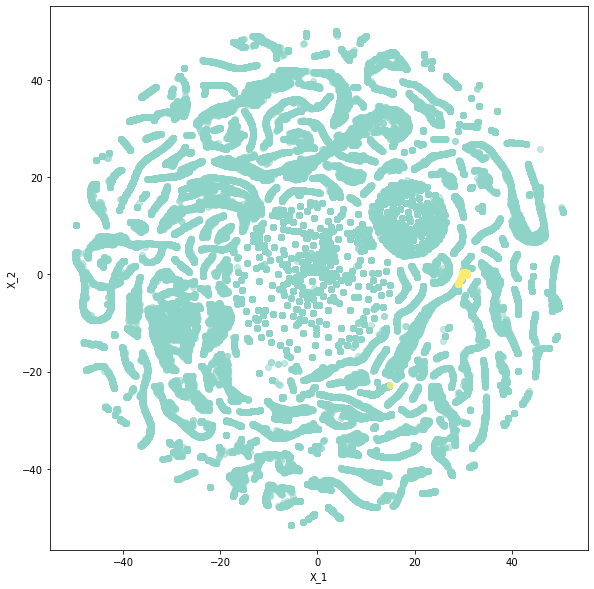

In [620]:

X_pd = pd.DataFrame({'X_0':X_reps_erc1155[:,0],
                     'X_1':X_reps_erc1155[:,1],
                    'y':y_preds})

X_non = X_pd[X_pd['y']==0]

X_scam = X_pd[X_pd['y']==1]

fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(X_non['X_0'],
           X_non['X_1'],
          c=plt.cm.Set3(0),
          alpha=0.5)
ax.scatter(X_scam['X_0'],
           X_scam['X_1'],
          c=plt.cm.Set3(plt.cm.Set3.N),
          alpha=0.75)

ax.set(aspect='equal',
      xlabel='X_1',
      ylabel='X_2',)

#plt.savefig('TSNE_ERC1155.jpeg')

In [323]:
# Research the predicted scam addresses
scam_indices = np.asarray([y_pred == 1])[0]

scam_ind = [test_index_ERC1155[i] for i in range(len(test_index_ERC1155)) if scam_indices[i]]

ERC1155_scams = pd.DataFrame({'address': feature_matrix_1155['address'][scam_ind]})

#ERC1155_scams.to_csv('data/ERC1155_scams.csv')


In [ ]:
#ERC1155_scams


In [324]:
ERC1155_scam_preds = pd.DataFrame({'address': ERC1155_scams['address'],
                                  'predicted_count': list(np.ones(len(ERC1155_scams['address'])))})

steps = 3
i = 0
j = 0
while (i < steps):
    ERC1155_Graph = tfg.Graph(x = X_feats,
                        edge_index = edge_Index,
                        edge_weight = edge_Weight).to_directed()
    erc1155_model = GCN_TL()
    erc1155_model.gcn0.build_cache_for_graph(ERC1155_Graph)
    
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.065)#0.0075 )

    erc1155_model.compile(optimizer = optimizer)
    
    model = erc1155_model
    graph = ERC1155_Graph
    train_index = train_index_ERC1155
    valid_index = train_index_ERC1155
    test_index = test_index_ERC1155
    
    print('Training... \n')
    for k in range(1280):
        train_step()
    
    # Initializing the model in order to set weights to the ERC20 model weights
    erc1155_model([X_feats, edge_Index, edge_Weight], 
                 training = False, cache = graph.cache)
    # Running model with weights equal to the layers in the ERC20 model
    logits = erc1155_model([X_feats, edge_Index, edge_Weight], 
                 training = False, cache = graph.cache)

    masked_logits = tf.gather(logits, np.arange(len(X_feats)))
    y_pred = tf.argmax(masked_logits, axis=-1, output_type=tf.int32)
    
    # Research the predicted scam addresses
    scam_indices = np.asarray([y_pred == 1])[0]

    scam_ind = [test_index_ERC1155[i] for i in range(len(test_index_ERC1155)) if scam_indices[i]]

    ERC1155_scams = pd.DataFrame({'address': feature_matrix_1155['address'][scam_ind]})
    
    print('Number of predicted scams: ', len(ERC1155_scams))
    
    if len(ERC1155_scams) < 15000 and len(ERC1155_scams) > 0:
        print('Index: ', i+1, ' / ', steps)
        #print('Number of predicted scams: ', len(ERC1155_scams))
        
        new_scams = [new for new in ERC1155_scams['address'] if ERC1155_scam_preds[ERC1155_scam_preds['address'] == new].empty]
        repeat_scam = [old for old in ERC1155_scams['address'] if not ERC1155_scam_preds[ERC1155_scam_preds['address'] == old].empty]
        print('Number of repeat predicted scams: ', len(repeat_scam))
    
        ERC1155_scam_preds = ERC1155_scam_preds.append(pd.DataFrame({'address':new_scams, 'predicted_count':np.ones(len(new_scams))}))
    
        for scam in repeat_scam:
            ERC1155_scam_preds.loc[ERC1155_scam_preds['address'] == scam, 'predicted_count'] = ERC1155_scam_preds[ERC1155_scam_preds['address'] == scam]['predicted_count'] + 1
        i = i + 1
        j = 0
    else:
        j = j + 1
        continue
    if j == 2*steps:
        print('Error. Taking too long.')
        break
        


Training... 

Number of predicted scams:  0
Training... 

Number of predicted scams:  111235
Training... 

Number of predicted scams:  150
Index:  1  /  3
Number of repeat predicted scams:  37
Training... 

Number of predicted scams:  112966
Training... 

Number of predicted scams:  0
Training... 

Number of predicted scams:  2
Index:  2  /  3
Number of repeat predicted scams:  0
Training... 

Number of predicted scams:  26488
Training... 

Number of predicted scams:  39323
Training... 

Number of predicted scams:  111875
Training... 

Number of predicted scams:  40081
Training... 

Number of predicted scams:  494
Index:  3  /  3
Number of repeat predicted scams:  5


In [325]:
print(len(ERC1155_scam_preds))

ERC1155_scam_preds = ERC1155_scam_preds.sort_values('predicted_count', ascending = False, ignore_index = True)
min_count = min(ERC1155_scam_preds['predicted_count'])
max_count = max(ERC1155_scam_preds['predicted_count'])

ERC1155_scam_preds_top = ERC1155_scam_preds
while len(ERC1155_scam_preds_top) > 1600:
    ERC1155_scam_preds_top = ERC1155_scam_preds[ERC1155_scam_preds['predicted_count'] > (min_count)]
    min_count = min_count + 1
if len(ERC1155_scam_preds_top) == 0:
    #ERC1155_scam_preds_top = ERC1155_scam_preds[ERC1155_scam_preds['predicted_count'] == max_count]
    ERC1155_scam_preds_top = ERC1155_scam_preds.iloc[range(int(len(ERC1155_scam_preds)*0.1))]



print(len(ERC1155_scam_preds_top))


726
726


### Retrying GCN with help from OpenWGL

In [326]:
ERC1155_scam_preds_top['label'] = ['unlabeled' for i in range(len(ERC1155_scam_preds_top))]


In [609]:
ERC1155_scam_preds_top[ERC1155_scam_preds_top['address'] == '0x8010d5c63d426c5809ab05ce27493e21b7022be0']

,address,predicted_count,label


## Labelling Predictions

In [331]:

#import http.cookiejar
#import urllib.parse
#import urllib.request

for adr in ERC1155_scam_preds_top['address']:

    adr_http = 'https://etherscan.io/address/' + adr
    req = Request(adr_http,  
              headers={'User-Agent': 'Mozilla/5.0'})
    page = urlopen(req)
    content = page.read()

    soup = BeautifulSoup(content)

    label = soup.findAll('div', attrs = {'class':'mt-1'})
    if len(label) > 1:
        label = label[1]
        rows = label.findAll('a')
        if len(rows) == 0:
            ERC1155_scam_preds_top.loc[ERC1155_scam_preds_top['address'] == adr, 'label'] = 'None'
        else:
            for row in rows:
                ERC1155_scam_preds_top.loc[ERC1155_scam_preds_top['address'] == adr, 'label'] = row.text
    else:
        ERC1155_scam_preds_top.loc[ERC1155_scam_preds_top['address'] == adr, 'label'] = 'None'

In [333]:
print(sorted(Counter(ERC1155_scam_preds_top['label']).items()))

#ERC1155_scam_preds_top.to_csv('data/ERC1155_scam_preds_labs.csv')
#ERC1155_scam_preds_top.to_csv('data/ERC1155_scam_preds_labs_2.csv')



[('Contract Deployer', 1), ('Eth2 Depositor', 1), ('MEV Bot', 1), ('None', 723)]
